## Hyper-parameters

In [22]:
import numpy as np
import tensorflow as tf
import random

config = {
    "WINDOW_SIZE": 30,
    "EPOCHS": 300, # Maximum epochs
    "BATCH_SIZE": 3000,
    "N_EXPERTS": 5, # Count of experts used in MoE technique
    "PATIENCE": 10, # Early stopping patience
    "RANDOM_SEED": 42,
    "INPUT_SEQUENCE_LENGTH": 29,
    "OUTPUT_SEQUENCE_LENGTH": 1,
    "STEP": 1,
    "LEARN_RATE": 0.005,
}

## Data loading and preprocessing



In [23]:
import yfinance as yf
from datetime import date
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the start and end dates for the data
START = "2015-01-01"
END = "2025-07-29"

def load_and_preprocess_data(ticker: str, input_sequence_length: int, output_sequence_length: int, step: int = 1):
    """
    Fetches data from Yahoo Finance, scales the features, and creates sequences and targets for prediction.
    """
    # Fetch historical stock data
    data = yf.download(ticker, START, END, progress=False)
    df = data[['Open', 'High', 'Low', 'Close', 'Volume']]

    # Initialize and fit a MinMaxScaler on the entire feature set
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Create sequences and corresponding targets
    close_price_index = df.columns.get_loc('Close')
    X, y = [], []
    for i in range(0, len(scaled_data) - input_sequence_length - output_sequence_length + 1, step):
        X.append(scaled_data[i:i+input_sequence_length])
        y.append(scaled_data[i+input_sequence_length:i+input_sequence_length+output_sequence_length, close_price_index]) # Target is the 'Close' price
    X, y = np.array(X), np.array(y)
    y = y.reshape(y.shape[0], y.shape[1])


    # Split into training and testing sets, 80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler, df.columns

# In this project, we use the stock price of Apple from 2015 to now as our dataset
X_train, X_test, y_train, y_test, scaler, columns = load_and_preprocess_data(
    'AAPL',
    config["INPUT_SEQUENCE_LENGTH"],
    config["OUTPUT_SEQUENCE_LENGTH"],
    step=config["STEP"]
)

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

/tmp/ipython-input-2299145219.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, START, TODAY, progress=False)


Training features shape: (2102, 29, 5)
Training labels shape: (2102, 1)
Testing features shape: (526, 29, 5)
Testing labels shape: (526, 1)


## Model Training and Evaluation

### Evaluation function


In [24]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def evaluate_model(model, X_test, y_test, scaler, columns):
    """
    Evaluates the performance of a trained model. The evaluation is based on inverse transformation of the predictions and actual values.
    """
    predictions = model.predict(X_test)

    rmse_scores, mae_scores = [], []
    close_price_index = columns.get_loc('Close')
    for i in range(y_test.shape[1]):
        # Create dummy arrays for inverse transformation
        dummy_predictions = np.zeros((len(predictions), scaler.n_features_in_))
        dummy_y_test = np.zeros((len(y_test), scaler.n_features_in_))

        # Place predictions and actual values for the current timestep in the correct column
        dummy_predictions[:, close_price_index] = predictions[:, i].reshape(-1, 1)
        dummy_y_test[:, close_price_index] = y_test[:, i].reshape(-1, 1)

        # Inverse transform the predictions and actual values
        predicted_close = scaler.inverse_transform(dummy_predictions)[:, close_price_index]
        actual_close = scaler.inverse_transform(dummy_y_test)[:, close_price_index]

        rmse_scores.append(root_mean_squared_error(actual_close, predicted_close))
        mae_scores.append(mean_absolute_error(actual_close, predicted_close))

    return np.mean(rmse_scores), np.mean(mae_scores)

### Naive LSTM (Baseline)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
random.seed(config["RANDOM_SEED"])
np.random.seed(config["RANDOM_SEED"])
tf.random.set_seed(config["RANDOM_SEED"])

def build_and_train_baseline_model(X_train, y_train, config):
    """
    Builds, trains, and evaluates the baseline LSTM model with early stopping.
    """
    # Build the baseline LSTM model
    output_sequence_length = config["OUTPUT_SEQUENCE_LENGTH"]
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])), # 29x5 (input sequence length & feature dimension)
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(output_sequence_length)
    ])
    optimizer = Adam(learning_rate=config["LEARN_RATE"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['MAE'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=config['EPOCHS'],
        batch_size=config['BATCH_SIZE'],
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

# Build and train the baseline model
print("\nTraining baseline model...")
baseline_model, baseline_history = build_and_train_baseline_model(X_train, y_train, config)
print("Baseline model trained.")
baseline_mse, baseline_mae = evaluate_model(baseline_model, X_test, y_test, scaler, columns)
print(f"Baseline LSTM Model -> RMSE: {baseline_mse:.4f}, MAE: {baseline_mae:.4f}")


Training baseline model...
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - MAE: 0.1722 - loss: 0.0622 - val_MAE: 0.0526 - val_loss: 0.0034
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - MAE: 0.0610 - loss: 0.0057 - val_MAE: 0.3348 - val_loss: 0.1132
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - MAE: 0.1678 - loss: 0.0404 - val_MAE: 0.0918 - val_loss: 0.0089
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - MAE: 0.0712 - loss: 0.0077 - val_MAE: 0.0917 - val_loss: 0.0089
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - MAE: 0.0400 - loss: 0.0041 - val_MAE: 0.1817 - val_loss: 0.0337
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - MAE: 0.0680 - loss: 0.0101 - val_MAE: 0.2028 - val_loss: 0.0418
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - MAE: 0.0788 - loss: 0.0126 - val_MAE: 0.1853 - val_loss: 0.0350
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - MAE: 0.0702 - loss: 0.0103 - val_MAE: 0.1479 - val_loss: 0.0225
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85m

### Mixture of Experts

In [26]:
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
random.seed(config["RANDOM_SEED"])
np.random.seed(config["RANDOM_SEED"])
tf.random.set_seed(config["RANDOM_SEED"])

def build_and_train_moe_model(X_train, y_train, config):
    """
    Builds, trains, and evaluates the Mixture of Experts (MoE) model with early stopping.
    """
    n_experts = config['N_EXPERTS']
    output_sequence_length = config['OUTPUT_SEQUENCE_LENGTH']

    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Create a list of expert models with uniform receiptive fields
    expert_outputs = []
    for i in range(n_experts):
        expert_lstm_1 = LSTM(64, return_sequences=False, name=f'expert_lstm_{i}_1')(input_layer)
        expert_dropout = Dropout(0.3)(expert_lstm_1)
        expert_dense = Dense(output_sequence_length, name=f'expert_dense_{i}')(expert_dropout)
        expert_outputs.append(expert_dense)

    # Create the gating network
    gating_lstm_1 = LSTM(16, return_sequences=False, name='gating_lstm_1')(input_layer)
    gating_network = Dense(n_experts, activation='softmax', name='gating_network')(gating_lstm_1)


    # Combine expert outputs using a weighted sum
    combined_experts = concatenate(expert_outputs)
    def weighted_sum(expert_outputs_and_weights):
        outputs, weights = expert_outputs_and_weights
        weights = tf.expand_dims(weights, axis=-1)
        outputs = tf.reshape(outputs, (-1, n_experts, output_sequence_length))
        return tf.reduce_sum(outputs * weights, axis=1)

    moe_output = Lambda(weighted_sum, name='moe_output')([combined_experts, gating_network])

    # Create and train the MoE model
    moe_model = Model(inputs=input_layer, outputs=moe_output)
    optimizer = Adam(learning_rate=config["LEARN_RATE"])
    moe_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['MAE'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = moe_model.fit(
        X_train, y_train,
        epochs=config['EPOCHS'],
        batch_size=config['BATCH_SIZE'],
        validation_split=0.1,
        callbacks=[early_stopping]
    )

    return moe_model, history

# Build and train
print("Training MoE model...")
moe_model, moe_history = build_and_train_moe_model(X_train, y_train, config)
print("MoE model trained.")
# Evaluate
moe_mse, moe_mae = evaluate_model(moe_model, X_test, y_test, scaler, columns)
print(f"MoE LSTM Model -> RMSE: {moe_mse:.4f}, MAE: {moe_mae:.4f}")

Training MoE model...
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - MAE: 0.2071 - loss: 0.0810 - val_MAE: 0.1181 - val_loss: 0.0149
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - MAE: 0.0527 - loss: 0.0046 - val_MAE: 0.3252 - val_loss: 0.1065
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - MAE: 0.1830 - loss: 0.0412 - val_MAE: 0.1422 - val_loss: 0.0207
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - MAE: 0.0971 - loss: 0.0111 - val_MAE: 0.0311 - val_loss: 0.0013
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - MAE: 0.0313 - loss: 0.0013 - val_MAE: 0.1322 - val_loss: 0.0181
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - MAE: 0.0444 - loss: 0.0049 - val_MAE: 0.1782 - val_loss: 0.0325
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - MAE: 0.0659 - loss: 0.0089 - val_MAE: 0.1825 - val_loss: 0.0340
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - MAE: 0.0691 - loss: 0.0091 - val_MAE: 0.1604 - val_loss: 0.0264
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms

### MoE with Multi-scale receptive fields

In [27]:
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
random.seed(config["RANDOM_SEED"])
np.random.seed(config["RANDOM_SEED"])
tf.random.set_seed(config["RANDOM_SEED"])

def build_and_train_moe_model_with_multiscale_temporal_experts(X_train, y_train, config):
    """
    Builds, trains, and evaluates the Mixture of Experts (MoE) model with multi-scale temporal receptive fields with early stopping.
    """

    output_sequence_length = config['OUTPUT_SEQUENCE_LENGTH']
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_moe_scale')

    # Define receptive fields for each expert
    receptive_field_windows = [2, 3, 4, 15, 29]
    expert_outputs = []

    for i, window in enumerate(receptive_field_windows):
        # Extract the target `window`
        def slice_last_steps(x, win=window):
            return x[:, -win:, :]
        sliced_input = Lambda(slice_last_steps, name=f'slice_{window}_days')(input_layer)

        expert_lstm = LSTM(64, return_sequences=False, name=f'expert_lstm_{i}')(sliced_input)
        expert_dropout = Dropout(0.3)(expert_lstm)
        expert_dense = Dense(output_sequence_length, name=f'expert_dense_{i}')(expert_dropout)
        expert_outputs.append(expert_dense)

    # Gating network
    gating_lstm = LSTM(32, return_sequences=False, name='gating_lstm')(input_layer)
    gating_output = Dense(len(receptive_field_windows), activation='softmax', name='gating_network')(gating_lstm)

    # Combine expert outputs using a weighted sum
    combined_experts = concatenate(expert_outputs, name='combined_experts')
    def weighted_sum(expert_outputs_and_weights):
        outputs, weights = expert_outputs_and_weights
        weights = tf.expand_dims(weights, axis=-1)  # (batch_size, n_experts, 1)
        outputs = tf.reshape(outputs, (-1, len(receptive_field_windows), output_sequence_length))
        return tf.reduce_sum(outputs * weights, axis=1)  # (batch_size, output_sequence_length)

    moe_output = Lambda(weighted_sum, name='moe_output')([combined_experts, gating_output])

    # Build model
    moe_model = Model(inputs=input_layer, outputs=moe_output)
    optimizer = Adam(learning_rate=config["LEARN_RATE"])
    moe_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = moe_model.fit(
        X_train, y_train,
        validation_split=0.1,
        batch_size=config['BATCH_SIZE'],
        epochs=config['EPOCHS'],
        callbacks=[early_stopping],
        verbose=1
    )

    return moe_model, history

# Build and train MoE model with multi-sscale experts
print("Training multi-scale temporal MoE model...")
multi_scale_temporal_moe_model, multi_scale_temporal_moe_history = build_and_train_moe_model_with_multiscale_temporal_experts(X_train, y_train, config)
print("Temporal MoE model trained.")

# Evaluate model performance
multi_scale_temporal_moe_rmse, multi_scale_temporal_moe_mae = evaluate_model(multi_scale_temporal_moe_model, X_test, y_test, scaler, columns)
print(f"Multi-scale Temporal MoE LSTM Model -> RMSE: {multi_scale_temporal_moe_rmse:.4f}, MAE: {multi_scale_temporal_moe_mae:.4f}")

Training multi-scale temporal MoE model...
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0875 - mae: 0.2146 - val_loss: 0.1059 - val_mae: 0.3226
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0251 - mae: 0.1037 - val_loss: 0.0060 - val_mae: 0.0715
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0051 - mae: 0.0648 - val_loss: 0.0275 - val_mae: 0.1646
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0200 - mae: 0.1366 - val_loss: 0.0180 - val_mae: 0.1326
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0142 - mae: 0.1153 - val_loss: 0.0021 - val_mae: 0.0418
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0052 - mae: 0.0681 - val_loss: 0.0017 - val_mae: 0.0369
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0020 - mae: 0.0404 - val_loss: 0.0081 - val_mae: 0.0870
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0022 - mae: 0.0340 - val_loss: 0.0135 - val_mae: 0.1139
Epoch 9/300
1/1 ━━━━━━━━

### Summary

In [28]:
import pandas as pd

# Create a summary of the results
results = {
    "Model": ["Baseline LSTM", "MoE LSTM", "Multi-scale Temporal MoE LSTM"],
    "RMSE": [baseline_mse, moe_mse, multi_scale_temporal_moe_rmse],
    "MAE": [baseline_mae, moe_mae, multi_scale_temporal_moe_mae]
}

results_df = pd.DataFrame(results)
display(results_df)

,Model,RMSE,MAE
0,Baseline LSTM,10.194771,8.375645
1,MoE LSTM,6.076037,4.629481
2,Multi-scale Temporal MoE LSTM,4.988581,3.530409


In [29]:
# Save 3 trained models
baseline_model.save('baseline_model.h5')
moe_model.save('moe_model.h5')
multi_scale_temporal_moe_model.save('multi_scale_temporal_moe_model.h5')

## Visualization

### Loss Curve

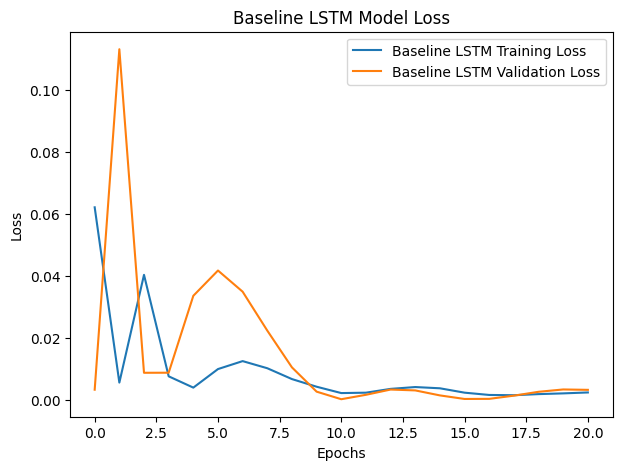

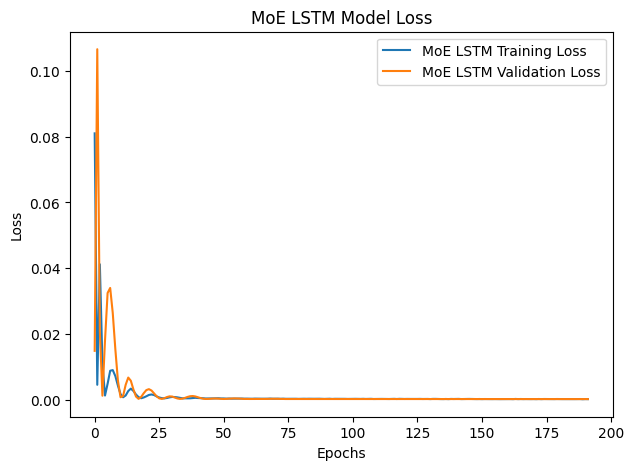

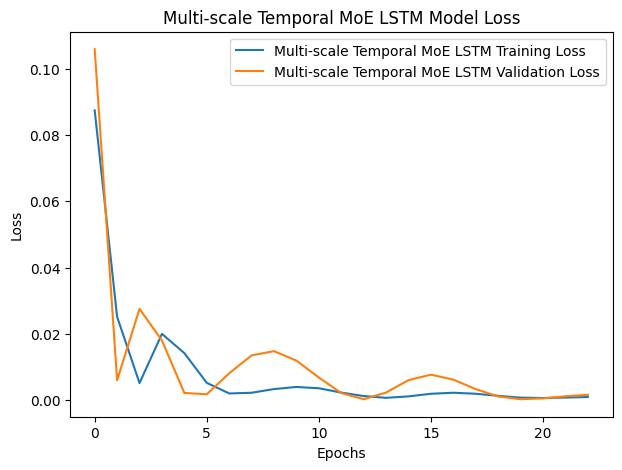

In [30]:
import matplotlib.pyplot as plt

def plot_loss_curves(training_history, model_name):
    """
    Plots the training and validation loss curves for all 3 models.
    """
    plt.figure(figsize=(7, 5))

    # Plot baseline model loss
    plt.plot(training_history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(training_history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the loss curves
plot_loss_curves(baseline_history, "Baseline LSTM")
plot_loss_curves(moe_history, "MoE LSTM")
plot_loss_curves(multi_scale_temporal_moe_history, "Multi-scale Temporal MoE LSTM")

### Sample prediction in short-term (20 days)

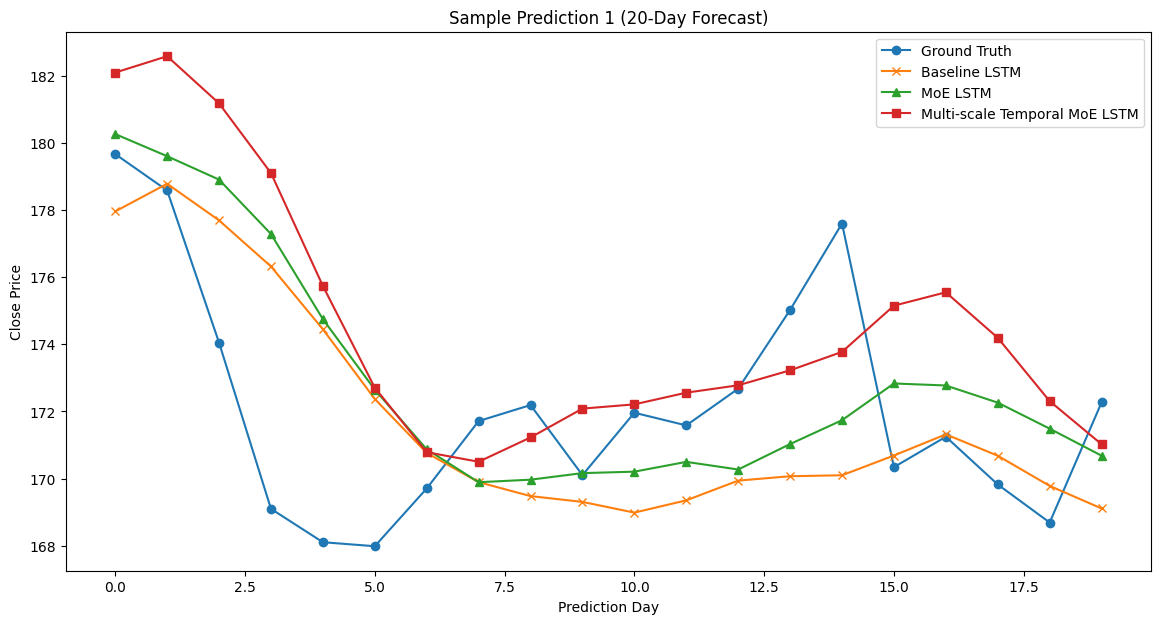

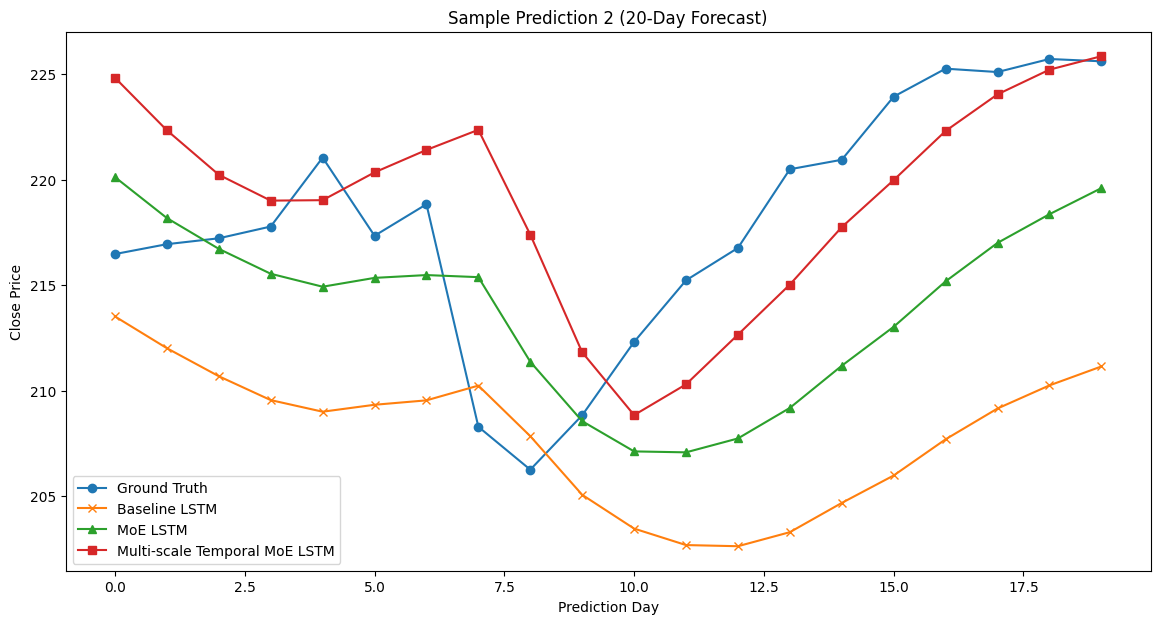

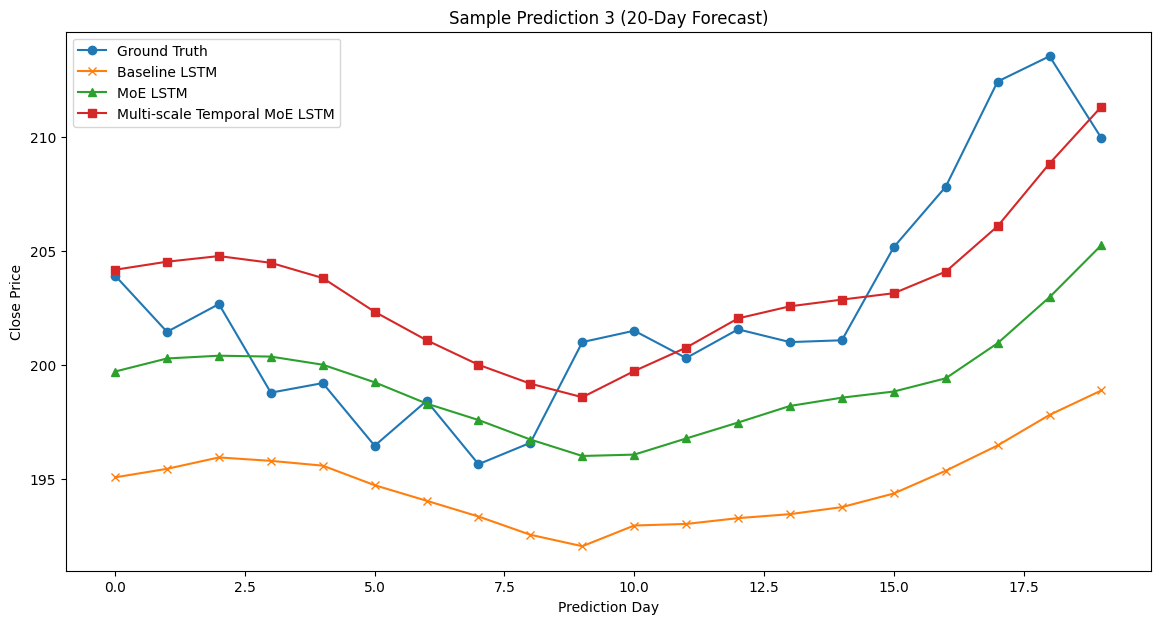

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_predictions(models, model_names, X_test, y_test, scaler, columns, n_samples=3, sample_indices=None, forecast_horizon=20):
    """
    Selects random samples from the test set and plots the predictions of all models against the ground truth for a given forecast horizon.
    """
    close_price_index = columns.get_loc('Close')
    if not sample_indices:
      sample_indices = np.random.choice(len(X_test) - forecast_horizon, n_samples, replace=False)

    for i, start_index in enumerate(sample_indices):
        plt.figure(figsize=(14, 7))
        plt.title(f'Sample Prediction {i+1} ({forecast_horizon}-Day Forecast)')

        ground_truth = y_test[start_index:start_index + forecast_horizon]
        model_preds = [[] for _ in models]

        for j in range(forecast_horizon):
            input_sequence = X_test[start_index + j:start_index + j + 1]
            for k, model in enumerate(models):
                next_pred = model.predict(input_sequence, verbose=0)
                model_preds[k].append(next_pred[0])

        def inverse_transform_preds(preds):
            preds_array = np.array(preds)
            dummy_preds = np.zeros((len(preds_array), scaler.n_features_in_))
            dummy_preds[:, close_price_index] = preds_array.reshape(-1, 1)
            return scaler.inverse_transform(dummy_preds)[:, close_price_index]

        model_preds_inv = [inverse_transform_preds(preds) for preds in model_preds]

        dummy_ground_truth = np.zeros((len(ground_truth), scaler.n_features_in_))
        dummy_ground_truth[:, close_price_index] = ground_truth.reshape(-1, 1)
        ground_truth_inv = scaler.inverse_transform(dummy_ground_truth)[:, close_price_index]

        # Plot the results
        plt.plot(range(forecast_horizon), ground_truth_inv, 'o-', label='Ground Truth')
        markers = ['x', '^', 's', 'd', '*']

        for k, preds_inv in enumerate(model_preds_inv):
            marker = markers[k % len(markers)]
            plt.plot(range(forecast_horizon), preds_inv, marker + '-', label=model_names[k])

        plt.xlabel('Prediction Day')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

# plot
models = [baseline_model, moe_model, multi_scale_temporal_moe_model]
model_names = ['Baseline LSTM', 'MoE LSTM', 'Multi-scale Temporal MoE LSTM']
plot_sample_predictions(models, model_names, X_test, y_test, scaler, columns, forecast_horizon=20)


### Sample prediction in long-term (200 days)

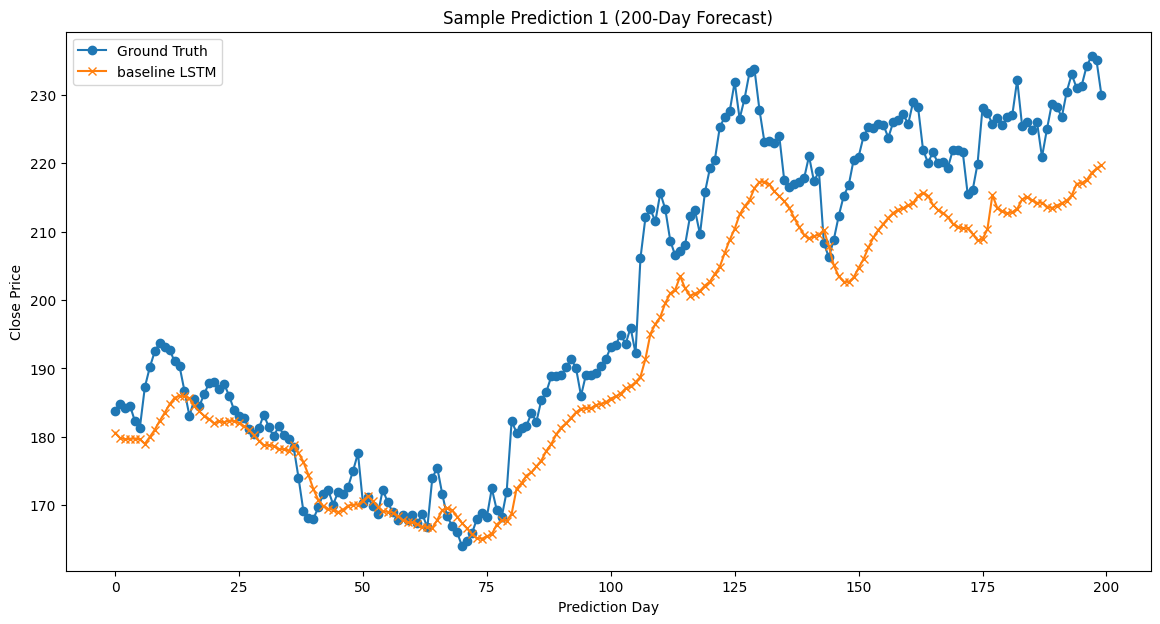

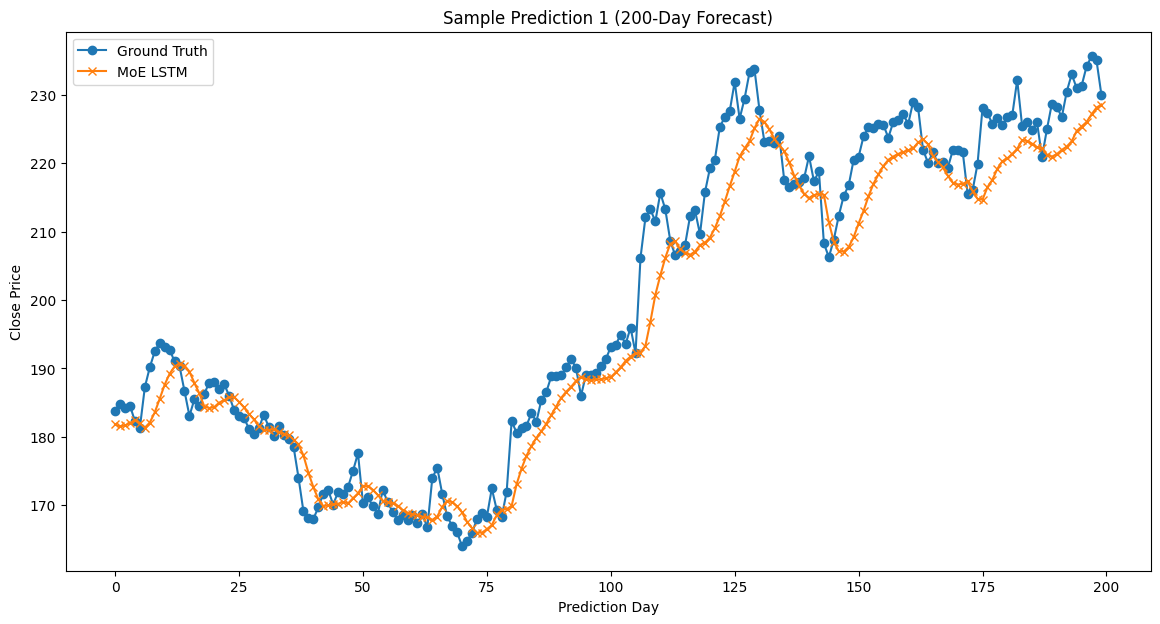

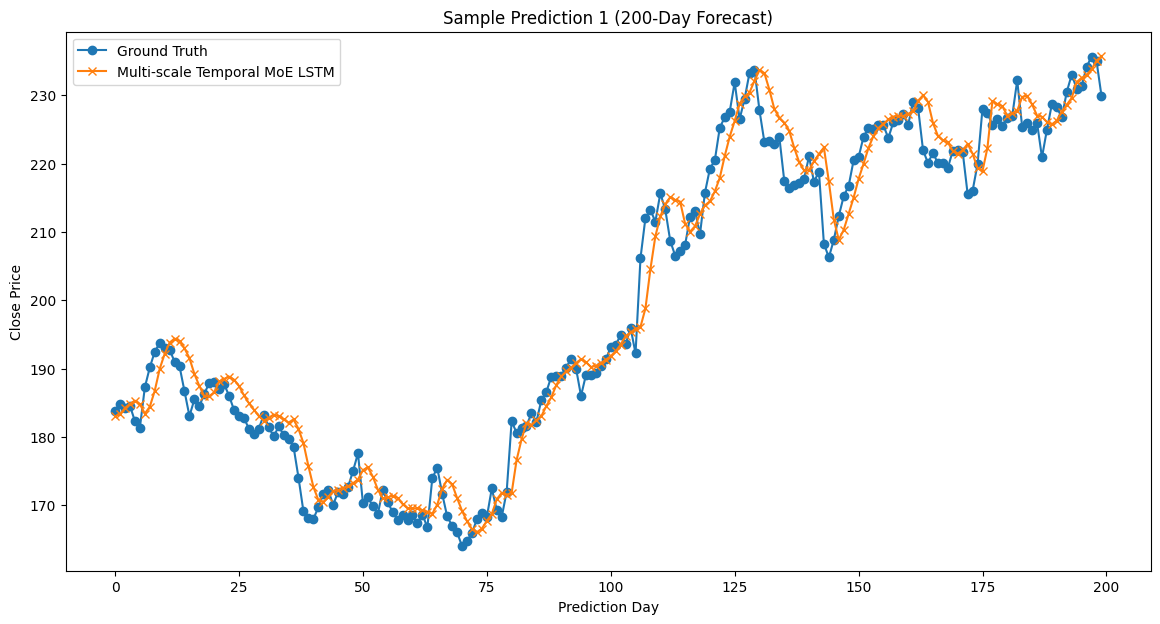

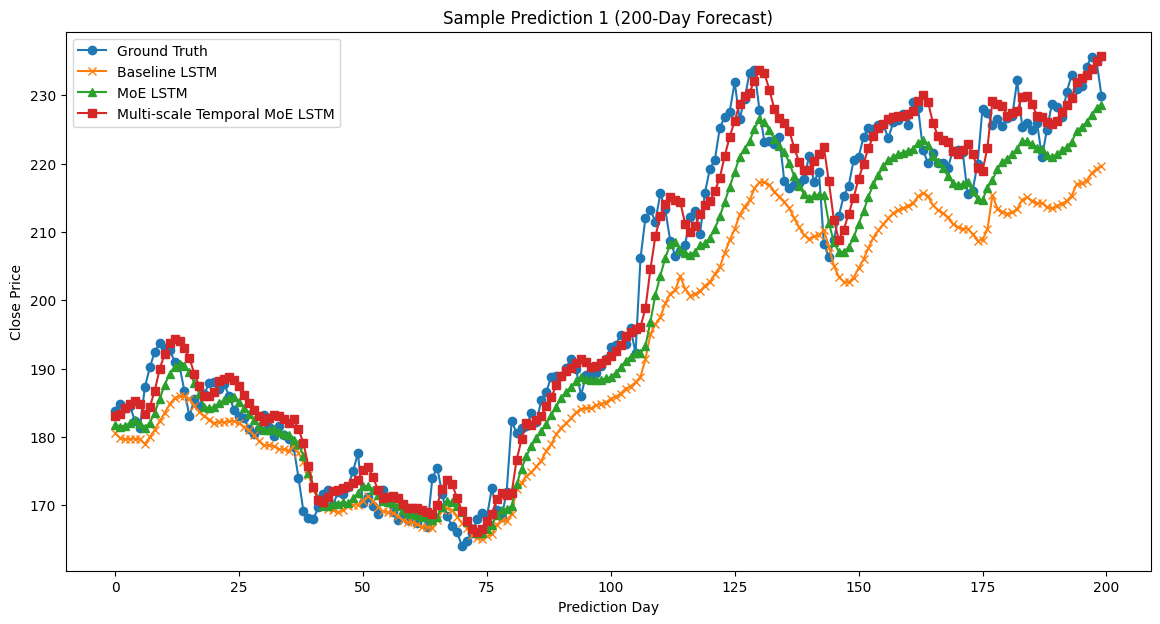

In [32]:
# plot respectively
sample_indice = np.random.choice(len(X_test) - 200, 1, replace=False)
plot_sample_predictions([baseline_model], ["baseline LSTM"], X_test, y_test, scaler, columns, sample_indices=sample_indice, forecast_horizon=200)
plot_sample_predictions([moe_model], ["MoE LSTM"], X_test, y_test, scaler, columns, sample_indices=sample_indice, forecast_horizon=200)
plot_sample_predictions([multi_scale_temporal_moe_model], ["Multi-scale Temporal MoE LSTM"], X_test, y_test, scaler, columns, sample_indices=sample_indice, forecast_horizon=200)
# Show in single plot
models = [baseline_model, moe_model, multi_scale_temporal_moe_model]
model_names = ['Baseline LSTM', 'MoE LSTM', 'Multi-scale Temporal MoE LSTM']
plot_sample_predictions(models, model_names, X_test, y_test, scaler, columns, sample_indices=sample_indice, forecast_horizon=200)